Mounting Google Drive to Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

Importing the Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

Plotting the Number of Images per Emotion for Training and Testing

In [ ]:
def plot_bar_chart(path_data):
  dic={}
  for emotion in  os.listdir(path_data):
    dem=0
    for x in os.listdir(path_data+"/"+emotion):
      dem+=1
    dic[emotion]=dem
  print(dic)
  barlist=plt.bar(range(len(dic)), list(dic.values()),tick_label=list(dic.keys()))
  plt.show()

{'neutral': 4965, 'fear': 4097, 'disgust': 436, 'sad': 4830, 'surprise': 3171, 'angry': 3995, 'happy': 7215}


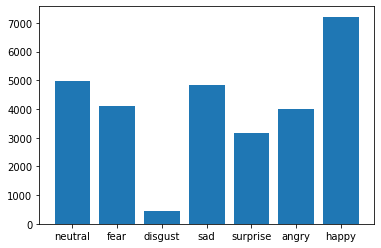

In [ ]:
plot_bar_chart('/content/train')

{'neutral': 1233, 'fear': 1024, 'disgust': 111, 'sad': 1247, 'surprise': 831, 'angry': 958, 'happy': 1774}


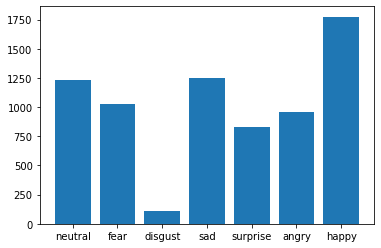

In [ ]:
plot_bar_chart('/content/test')

Creating Directory Iterators and doing Data Augmentation on Training Set

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
train_set=train_datagen.flow_from_directory('/content/train',target_size=(48,48),color_mode='rgb',class_mode='categorical',batch_size=64)

Found 28709 images belonging to 7 classes.


In [ ]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow_from_directory('/content/test',target_size=(48,48),color_mode='rgb',class_mode='categorical',batch_size=64)

Found 7178 images belonging to 7 classes.


Creating the CNN model

In [ ]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,Dropout,Dense,Flatten
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='gelu', input_shape=(48, 48,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='gelu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'gelu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'gelu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)      

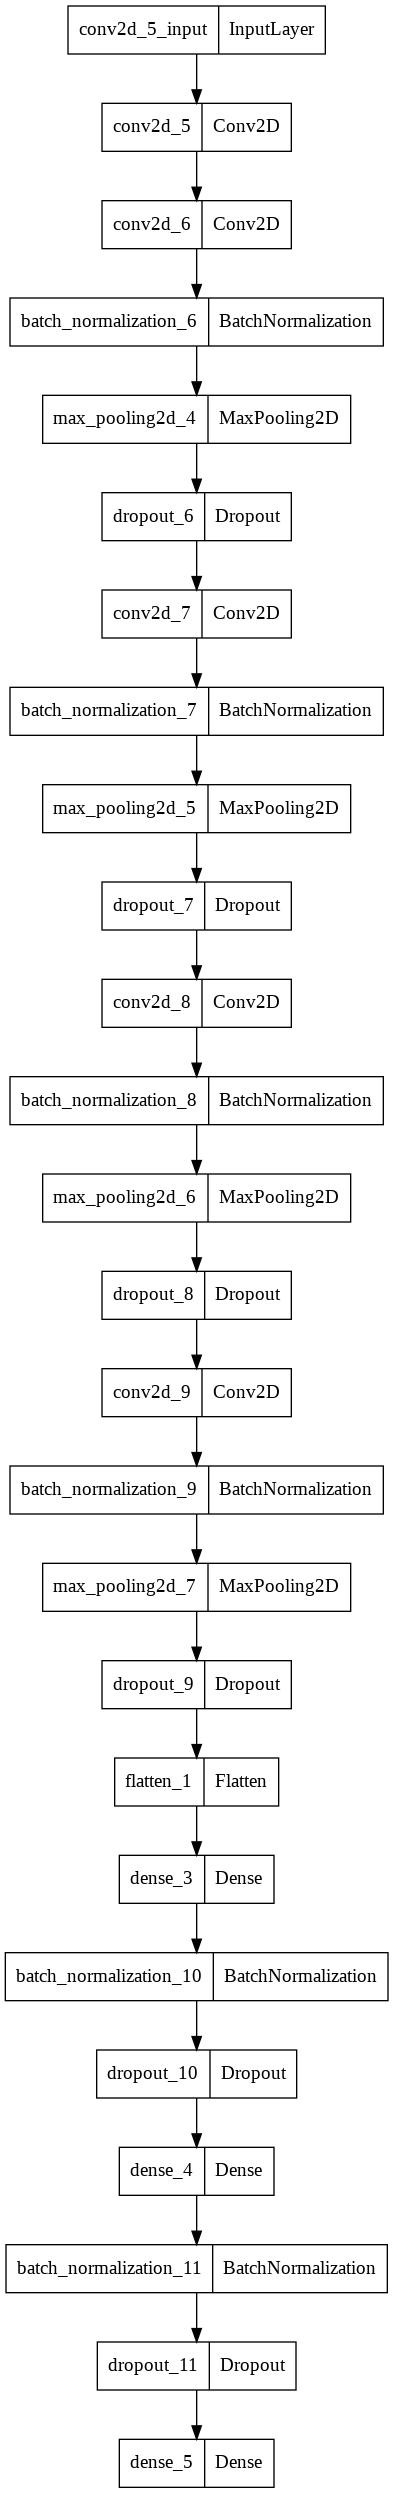

In [ ]:
from google.colab.patches import cv2_imshow
tf.keras.utils.plot_model(model,to_file='photo.jpg')
img=cv2.imread('photo.jpg')
cv2_imshow(img)

Adding Class Weights and Early Stoppig

In [ ]:
class_weights={0:1.80,
               1:16.54,
               2:1.76,
               3:1.,
               4:1.45,
               5:1.49,
               6:2.27
               }
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = tf.keras.callbacks.ModelCheckpoint('model_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Compiling and Training the Model

In [ ]:
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['Accuracy'])

In [ ]:
history=model.fit_generator(train_set,validation_data=test_set,callbacks=[es,mc],verbose=1,class_weight=class_weights,epochs=50)

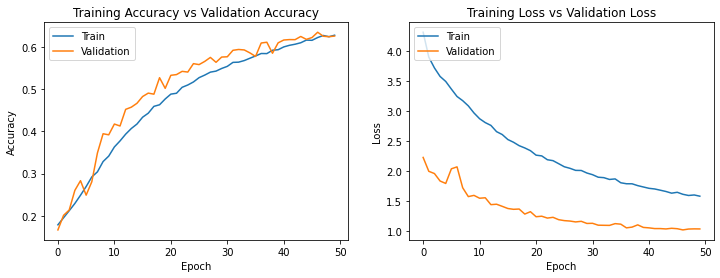

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['Accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['Accuracy'])
ax[0].plot(history.history['val_Accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('seaborn-darkgrid')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes= ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
test_path="/content/test"
validation_datagen1= tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test1_generator = validation_datagen1.flow_from_directory(directory=test_path, batch_size=64, classes=classes,class_mode="categorical", target_size=(48,48), shuffle=False)
y_true = test1_generator.classes
y_hat =  model.predict(test1_generator)
y_hat = tf.argmax(y_hat, axis = 1).numpy()

Found 7178 images belonging to 7 classes.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
accuracy = accuracy_score(y_true, y_hat,)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_true, y_hat,average='micro')
f1 = f1_score(y_true, y_hat,average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.625801
F1 score: 0.625801


Confusion matrix, without normalization
[[ 564   66   61   35  105   90   37]
 [  12   90    0    3    2    2    2]
 [ 159   34  365   30  110  174  152]
 [  63    9   35 1457  118   39   53]
 [ 114    5   65   79  796  127   47]
 [ 195   27  136   60  269  520   40]
 [  21    6   44   26   18   16  700]]


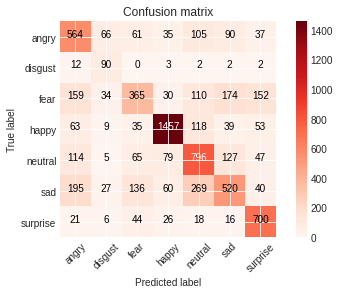

In [ ]:
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')

In [ ]:
model.save('my_model.h5')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


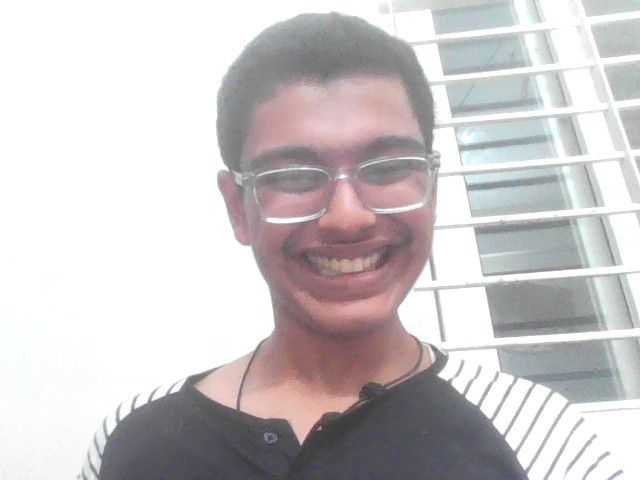

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
webcam_img=tf.keras.utils.load_img('/content/photo.jpg',target_size=(48,48),color_mode='rgb')
webcam_img=tf.keras.utils.img_to_array(webcam_img)
webcam_img=np.expand_dims(webcam_img,axis=0)
result=model.predict(webcam_img)

In [ ]:
max=0
maxpos=0
for i in range(7):
  if(result[0][i]>max):
    max=result[0][i]
    maxpos=i
if(maxpos==0):
  prediction='anger'
elif(maxpos==1):
  prediction='disgust'
elif(maxpos==2):
  prediction='fear'
elif(maxpos==3):
  prediction='happiness'
elif(maxpos==4):
  prediction='neutral'
elif(maxpos==5):
  prediction='sadness'
else:
  prediction='surprise'
print("The Emotion detected is:",prediction)

The Emotion detected is: fear
